In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from registration_utilities import *
from metadata import *
from data_manager import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

Setting environment for Gordon


In [2]:
stack_fixed = 'MD591'

In [3]:
train_sample_scheme = 1
global_transform_scheme = 1

stack_moving = 'atlas_on_MD589'

In [4]:
paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', 'SNC', 'SNR', '3N', '4N',
                    'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']
structures = paired_structures + singular_structures

In [5]:
label_to_name_fixed = {i+1: name for i, name in enumerate(sorted(structures))}
name_to_label_fixed = {n:l for l, n in label_to_name_fixed.iteritems()}

In [6]:
label_to_name_moving = {i+1: name for i, name in enumerate(sorted(structures) + sorted([s+'_surround' for s in structures]))}
name_to_label_moving = {n:l for l, n in label_to_name_moving.iteritems()}

In [7]:
volume_fixed = {name_to_label_fixed[name]: DataManager.load_score_volume(stack=stack_fixed, label=name, downscale=32, train_sample_scheme=train_sample_scheme)
               for name in structures}

print volume_fixed.values()[0].shape
print volume_fixed.values()[0].dtype

vol_fixed_xmin, vol_fixed_ymin, vol_fixed_zmin = (0,0,0)
vol_fixed_ymax, vol_fixed_xmax, vol_fixed_zmax = np.array(volume_fixed.values()[0].shape) - 1

(410, 500, 375)
float16


In [8]:
# volume_moving = {name_to_label_moving[name]: DataManager.load_score_volume(stack_moving, label=name, downscale=32)
#                  for name in structures + [s+'_surround' for s in structures]}

volume_moving = {name_to_label_moving[name]: DataManager.load_score_volume(stack=stack_moving, label=name, downscale=32, train_sample_scheme=None)
               for name in structures}

print volume_moving.values()[0].shape
print volume_moving.values()[0].dtype

vol_moving_xmin, vol_moving_ymin, vol_moving_zmin = (0,0,0)
vol_moving_ymax, vol_moving_xmax, vol_moving_zmax = np.array(volume_moving.values()[0].shape) - 1

(348, 421, 377)
float16


In [9]:
volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

In [10]:
def convert_to_original_name(name):
    return name.split('_')[0]

labelIndexMap_m2f = {}
for label_m, name_m in label_to_name_moving.iteritems():
    labelIndexMap_m2f[label_m] = name_to_label_fixed[convert_to_original_name(name_m)]

label_weights_m = {}
for label_m, name_m in label_to_name_moving.iteritems():
    if 'surround' in name_m:
        label_weights_m[label_m] = 0
    else:
#         label_weights_m[label_m] = 1
        label_weights_m[label_m] = np.minimum(1e5 / volume_moving_structure_sizes[label_m], 1.)

In [12]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=labelIndexMap_m2f)

In [13]:
aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
# aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[name_to_label_moving['SNR_R']])

In [14]:
gradient_filepath_map_f = {ind_f: DataManager.get_score_volume_gradient_filepath_template(stack=stack_fixed, label=label_to_name_fixed[ind_f],
                            downscale=32, train_sample_scheme=train_sample_scheme)
                            for ind_m, ind_f in labelIndexMap_m2f.iteritems()}

In [15]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f, indices_f=None)

set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])


load gradient 1: 1.493399 seconds
load gradient 2: 1.811338 seconds
load gradient 3: 2.258246 seconds
load gradient 4: 1.544926 seconds
load gradient 5: 2.080355 seconds
load gradient 6: 1.126231 seconds
load gradient 7: 2.022228 seconds
load gradient 8: 1.383766 seconds
load gradient 9: 1.464932 seconds
load gradient 10: 1.865901 seconds
load gradient 11: 2.302605 seconds
load gradient 12: 2.492635 seconds
load gradient 13: 1.658402 seconds
load gradient 14: 2.766468 seconds
load gradient 15: 2.080580 seconds
load gradient 16: 3.059513 seconds
load gradient 17: 3.129765 seconds
load gradient 18: 2.897096 seconds
load gradient 19: 2.625509 seconds
load gradient 20: 2.657488 seconds
load gradient 21: 2.685358 seconds
load gradient 22: 2.171030 seconds
load gradient 23: 2.592414 seconds
load gradient 24: 2.669942 seconds
load gradient 25: 1.460866 seconds
load gradient 26: 1.772610 seconds
load gradient 27: 2.074031 seconds
load gradient 28: 2.326803 seconds
overall: 60.478691 seconds


In [18]:
# largely the same optimization path regardless of the starting condition

# For rigid, 
# grad_computation_sample_number = 1e5 is desired
# grid_search_iteration_number and grid_search_sample_number seem to be unimportant as well, set to 100
# lr1=10, lr2=.1 is best

# For affine, 
# lr2 = .001 is too slow; 0.1 rises faster than 0.01
# lr1 does not matter
# plateus around iteration 100, but keep rising afterwards.
# grad_computation_sample_number does not make a difference

while True:

    try:

        if global_transform_scheme == 1:

            T, scores = aligner.optimize(type='affine', max_iter_num=1000, history_len=10, terminate_thresh=1e-4,
#                                          indices_m=[name_to_label_moving['SC'], name_to_label_moving['IC'],
#                                                    name_to_label_moving['SC_surround'], name_to_label_moving['IC_surround']],
                                         indices_m=None,
                                        grid_search_iteration_number=30,
                                         grid_search_sample_number=100,
                                         grad_computation_sample_number=1e5,
                                         lr1=10, lr2=0.1,
                                         label_weights=label_weights_m,
                                        std_tx=50, std_ty=50, std_tz=100, std_theta_xy=np.deg2rad(10))

        elif global_transform_scheme == 2:

            T, scores = aligner.optimize(type='rigid', max_iter_num=1000, history_len=10, terminate_thresh=1e-4,
                                         indices_m=None,
                                        grid_search_iteration_number=30,
                                         grid_search_sample_number=100,
                                         grad_computation_sample_number=1e5,
                                         lr1=10, lr2=0.1,
                                        label_weights=label_weights_m,
                                        std_tx=50, std_ty=50, std_tz=100, std_theta_xy=np.deg2rad(10))
        
        break
        
    except Exception as e:
        sys.stderr.write(e.message + '\n')


Regularization weights not set, default to 0.
grid search: 5.545859 seconds
-inf 0.578705
grid search: 3.431956 seconds
0.578705 0.585805
grid search: 3.125207 seconds
grid search: 2.439176 seconds
0.585805 0.681889
grid search: 1.723273 seconds
0.681889 0.694617
grid search: 1.326836 seconds
grid search: 1.018046 seconds
0.694617 0.711307
grid search: 1.027550 seconds
grid search: 0.718926 seconds
0.711307 0.712345
grid search: 0.616953 seconds
0.712345 0.715369
grid search: 0.624349 seconds
0.715369 0.715818
grid search: 0.625012 seconds
grid search: 0.602228 seconds
0.715818 0.716395
grid search: 0.612138 seconds
0.716395 0.717500
grid search: 0.612965 seconds
grid search: 0.625687 seconds
grid search: 0.615799 seconds
grid search: 0.614354 seconds
grid search: 0.612036 seconds
grid search: 0.609570 seconds
grid search: 0.624845 seconds
grid search: 0.621502 seconds
grid search: 0.622832 seconds
grid search: 0.613414 seconds
grid search: 0.608791 seconds
grid search: 0.625234 second

params_best_upToNow [-17.73277214  -1.83274607   9.31176434  -0.14247366]


score: 0.717500
iteration 1
score: 0.535422
iteration 2
score: 0.682641
iteration 3
score: 0.705039
iteration 4
score: 0.756221
iteration 5
score: 0.793130
iteration 6
score: 0.795609
iteration 7
score: 0.788319
iteration 8
score: 0.807133
iteration 9
score: 0.847564
iteration 10
score: 0.836601
iteration 11
score: 0.800343
iteration 12
score: 0.837466
iteration 13
score: 0.837481
iteration 14
score: 0.853410
iteration 15
score: 0.856843
iteration 16
score: 0.857318
iteration 17
score: 0.870539
iteration 18
score: 0.867775
iteration 19
score: 0.879637
iteration 20
score: 0.874726
iteration 21
score: 0.885392
iteration 22
score: 0.881795
iteration 23
score: 0.887887
iteration 24
score: 0.885897
iteration 25
score: 0.892960
iteration 26
score: 0.889649
iteration 27
score: 0.892490
iteration 28
score: 0.890882
iteration 29
score: 0.893930
iteration 30
score: 0.894358
iteration 31
score: 0.895441
iteration 32
score: 0.894701
iteration 33
score: 0.896087
iteration 34
score: 0.894868
iterati

[[  1.03128554e+00   1.65617998e-01   4.81374869e-02  -1.14661231e+01]
 [ -1.13813027e-01   1.00588426e+00   2.46397815e-03   3.33518624e+00]
 [ -1.25397810e-02  -6.05162450e-02   9.14412920e-01   5.12857099e+00]]
0.904704561958 0.904658131699


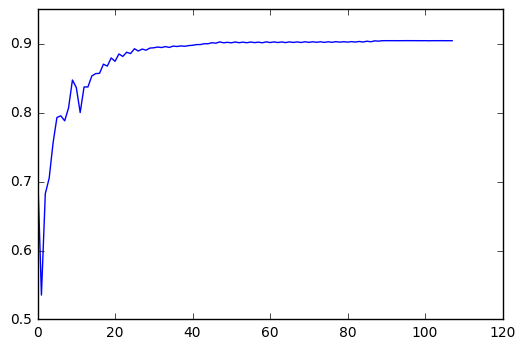

In [19]:
print T.reshape((3,4))
plt.plot(scores);
print max(scores), scores[-1]

In [20]:
params_fp = DataManager.get_global_alignment_parameters_filepath(stack_moving=stack_moving,
                                                                stack_fixed=stack_fixed,
                                                                train_sample_scheme=train_sample_scheme,
                                                                global_transform_scheme=global_transform_scheme)


DataManager.save_alignment_parameters(params_fp, T, 
                                      aligner.centroid_m, aligner.centroid_f,
                                      aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                      aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [21]:
score_plot_fp = DataManager.get_global_alignment_score_plot_filepath(stack_moving=stack_moving,
                                                                    stack_fixed=stack_fixed,
                                                                    train_sample_scheme=train_sample_scheme,
                                                                    global_transform_scheme=global_transform_scheme)

fig = plt.figure();
plt.plot(scores);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)

In [24]:
# READ

In [16]:
# stack_fixed = 'MD591'
stack_moving = 'atlas_on_MD589'

In [19]:
global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
DataManager.load_global_alignment_parameters(stack_moving=stack_moving,
                                                    stack_fixed=stack_fixed,
                                                    train_sample_scheme=train_sample_scheme,
                                                    global_transform_scheme=global_transform_scheme,
                                            trial_idx=1)

In [15]:
# volumes_annotation = {'MD594':bp.unpack_ndarray_file('/home/yuncong/csd395/CSHL_atlasAlignParams_atlas_v2/MD594_to_MD589/MD594_down32_annotationVolume_alignedTo_MD589_down32_annotationVolume.bp'),
#                       'MD589': bp.unpack_ndarray_file(VOLUME_ROOTDIR + '/MD589/MD589_down32_annotationVolume.bp')}

In [20]:
volumes_annotation = {'MD594': bp.unpack_ndarray_file(DataManager.get_transformed_volume_filepath(stack_m='MD594', type_m='annotation',
                                                stack_f='MD589', type_f='annotation',
                                                downscale=32, global_transform_scheme=global_transform_scheme)),
                      
                      'MD589': bp.unpack_ndarray_file(DataManager.get_annotation_volume_filepath(stack='MD589', downscale=32))}

In [21]:
from registration_utilities import transform_volume

In [22]:
annotation_volumes_volume_m_aligned_to_f = {}

for stack, volume_annotation in volumes_annotation.iteritems():
    
    annotation_volumes_volume_m_aligned_to_f[stack] = transform_volume(vol=volume_annotation, 
                                                                       global_params=global_params, 
                                                                       centroid_m=centroid_m, 
                                                                       centroid_f=centroid_f,
                                                                      xdim_f=xdim_f,
                                                                      ydim_f=ydim_f,
                                                                      zdim_f=zdim_f)
    
    output_fn = DataManager.get_transformed_volume_filepath(stack_m=stack, type_m='annotation',
                                                stack_f=stack_fixed, type_f='score',
                                                downscale=32, train_sample_scheme_f=train_sample_scheme)
    
    create_if_not_exists(os.path.dirname(output_fn))

    bp.pack_ndarray_file(annotation_volumes_volume_m_aligned_to_f[stack], output_fn)

In [23]:
xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f = \
DataManager.load_score_volume_bbox(stack=stack_fixed, label='7N', downscale=32)

print xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f

0 499 0 409 131 505


In [24]:
from registration_utilities import find_contour_points

In [25]:
downsample_factor = 32
xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
voxel_z_size = section_thickness / xy_pixel_distance_downsampled

In [26]:
viz_dir = create_if_not_exists(DataManager.get_global_alignment_viz_filepath(stack_moving=stack_moving,
                                                        stack_fixed=stack_fixed,
                                                        train_sample_scheme=train_sample_scheme,
                                                        global_transform_scheme=global_transform_scheme))

In [27]:
first_sec, last_sec = metadata_cache['section_limits'][stack_fixed]

In [28]:
stack_colors = {'MD589': (255,0,0), 'MD594': (0,255,0)}

In [29]:
bar = show_progress_bar(first_sec, last_sec)

for sec in range(first_sec, last_sec+1):
    
    if metadata_cache['sections_to_filenames'][stack_fixed][sec] in ['Placeholder', 'Rescan', 'Nonexisting']:
        continue
    
    bar.value = sec

    img_fn = DataManager.get_image_filepath(stack=stack_fixed, section=sec, resol='thumbnail', version='cropped_tif')
    img = imread(img_fn)
    
    viz = img.copy()
    
    z = voxel_z_size * (sec - 1) - zmin_vol_f
    
    # Find fixed volume annotation contours
#     contours_f_on_volume = find_contour_points(volume_fixed[..., int(z)])
#     contours_f_on_cropped = {i: [cnt + (xmin_vol_f, ymin_vol_f) for cnt in cnts] for i, cnts in contours_f_on_volume.iteritems()}

    # Find moving volume annotation contours
    
    for stack, volume_m_aligned_to_f in annotation_volumes_volume_m_aligned_to_f.iteritems():
        contours_m_alignedTo_f_on_volume = find_contour_points(volume_m_aligned_to_f[..., int(z)])
        contours_m_alignedTo_f_on_cropped = {i: [cnt + (xmin_vol_f, ymin_vol_f) for cnt in cnts] 
                                             for i, cnts in contours_m_alignedTo_f_on_volume.iteritems()}

    #     # Draw fixed volume annotation contours
    #     for ind_f, cnts_f in contours_f_on_cropped.iteritems():
    #         for cnt_f in cnts_f:
    #             cv2.polylines(viz, [cnt_f.astype(np.int)], True, (0,255,0), 2)

        # Draw moving volume annotation contours
        for ind_m, cnts_m in contours_m_alignedTo_f_on_cropped.iteritems():
            for cnt_m in cnts_m:
                cv2.polylines(viz, [cnt_m.astype(np.int)], True, stack_colors[stack], 2)

    viz_fn = os.path.join(viz_dir, '%(stack_moving)s_to_%(stack_fixed)s_%(sec)04d.jpg' % \
          {'stack_moving': stack_moving, 'stack_fixed': stack_fixed, 'sec': sec})
    imsave(viz_fn, viz)

/oasis/projects/nsf/csd395/yuncong/brain_virtualenv/lib/python2.7/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


In [19]:
from registration_utilities import transform_volume

In [24]:
# v = DataManager.load_score_volume(stack='atlas_on_MD589', label='7N_L', downscale=32)

# plt.imshow(v[:,:,120]);
# plt.colorbar();
# plt.show();

# plt.imshow(v[:,:,270]);
# plt.colorbar();
# plt.show();

In [25]:
# Transform moving volume, sided

structures_sided = sum([[n] if n in singular_structures else [convert_to_left_name(n), convert_to_right_name(n)] 
                        for n in structures], [])

for name_s in structures_sided:
    
    print name_s
    
    vol_m = DataManager.load_score_volume(stack=stack_moving, label=name_s, downscale=32)
    
    volume_m_alignedTo_f = \
    transform_volume(vol=vol_m, global_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f,
                      xdim_f=xdim_f, ydim_f=ydim_f, zdim_f=zdim_f)
    
    volume_m_alignedTo_f_fn = DataManager.get_transformed_volume_filepath(stack_m=stack_moving, type_m='score',
                                            stack_f=stack_fixed, type_f='score',
                                            label=name_s,
                                            downscale=32, 
                                            train_sample_scheme_f=1)
    
    create_if_not_exists(os.path.dirname(volume_m_alignedTo_f_fn))
    
    bp.pack_ndarray_file(volume_m_alignedTo_f, volume_m_alignedTo_f_fn)

5N_L
5N_R
6N_L
6N_R
7N_L
7N_R
7n_L
7n_R
Amb_L
Amb_R
LC_L
LC_R
LRt_L
LRt_R
Pn_L
Pn_R
Tz_L
Tz_R
VLL_L
VLL_R
RMC_L
RMC_R
SNC_L
SNC_R
SNR_L
SNR_R
3N_L
3N_R
4N_L
4N_R
Sp5I_L
Sp5I_R
Sp5O_L
Sp5O_R
Sp5C_L
Sp5C_R
PBG_L
PBG_R
10N_L
10N_R
VCA_L
VCA_R
VCP_L
VCP_R
DC_L
DC_R
AP
12N
RtTg
SC
IC


In [20]:
# Transform moving volume, sided

structures_sided = sum([[n] if n in singular_structures else [convert_to_left_name(n), convert_to_right_name(n)] 
                        for n in structures], [])

for name_s in structures_sided:
    
    print name_s+'_surround'
    
    vol_m = DataManager.load_score_volume(stack=stack_moving, label=name_s+'_surround', downscale=32)
    
    volume_m_alignedTo_f = \
    transform_volume(vol=vol_m, global_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f,
                      xdim_f=xdim_f, ydim_f=ydim_f, zdim_f=zdim_f)
    
    volume_m_alignedTo_f_fn = DataManager.get_transformed_volume_filepath(stack_m=stack_moving, type_m='score',
                                            stack_f=stack_fixed, type_f='score',
                                            label=name_s+'_surround',
                                            downscale=32, 
                                            train_sample_scheme_f=1)
    
    create_if_not_exists(os.path.dirname(volume_m_alignedTo_f_fn))
    
    bp.pack_ndarray_file(volume_m_alignedTo_f, volume_m_alignedTo_f_fn)

5N_L
5N_R
6N_L
6N_R
7N_L
7N_R
7n_L
7n_R
Amb_L
Amb_R
LC_L
LC_R
LRt_L
LRt_R
Pn_L
Pn_R
Tz_L
Tz_R
VLL_L
VLL_R
RMC_L
RMC_R
SNC_L
SNC_R
SNR_L
SNR_R
3N_L
3N_R
4N_L
4N_R
Sp5I_L
Sp5I_R
Sp5O_L
Sp5O_R
Sp5C_L
Sp5C_R
PBG_L
PBG_R
10N_L
10N_R
VCA_L
VCA_R
VCP_L
VCP_R
DC_L
DC_R
AP
12N
RtTg
SC
IC
